## Lecture 5: Classification with perceptron model

In [42]:
%matplotlib inline
import os
from tqdm import tqdm
import time
import pickle
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from torchvision import datasets
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as function

save_path = './'

In [43]:
with open('../bin/slp/test_features.pckl', 'rb') as f:
	test_features = pickle.load(f)
with open('../bin/slp/test_label.pckl', 'rb') as f:
	test_label = pickle.load(f)
with open('../bin/slp/train_features.pckl', 'rb') as f:
	train_features = pickle.load(f)
with open('../bin/slp/train_label.pckl', 'rb') as f:
	train_label= pickle.load(f)

In [44]:
# Defining a Perceptron

class perceptron(nn.Module):
	def __init__(self, n_channels):
		super(perceptron, self).__init__()
		self.L = nn.Linear(n_channels, 10)
	def forward(self, x):
		x = self.L(x)
		x = function.softmax(x) 
		return x


In [45]:
# Generating 1-hot label encoding
train_label_1hot = np.zeros((50000, 10))
test_label_1hot = np.zeros((10000, 10))
for d1 in range(train_label.shape[0]):
	train_label_1hot[d1, train_label[d1]] = 1
for d2 in range(test_label.shape[0]):
	test_label_1hot[d2, test_label[d2]] = 1

In [46]:
use_gpu = torch.cuda.is_available()
if use_gpu:
	print('GPU is available!')
	pin_mem = True
	device = "cuda"
else :
	print('GPU is not available!')
	pin_mem = False
	device = "cpu"

GPU is available!


In [47]:
# creating TensorDataset
train_dataset = TensorDataset(torch.from_numpy(train_features), torch.from_numpy(train_label_1hot))
test_dataset = TensorDataset(torch.from_numpy(test_features), torch.from_numpy(test_label_1hot))

# creating DataLoader
train_dataloader = DataLoader(train_dataset, num_workers= 4, batch_size= 64, shuffle=True, pin_memory=pin_mem)
test_dataloader = DataLoader(test_dataset, num_workers= 4, batch_size= 64, shuffle=False, pin_memory=pin_mem)

## Defining function for training the network

In [ ]:
# defining the training model
def train_model(model, criterion, num_epochs, learning_rate):
	start = time.time()
	train_loss = []
	train_accuracy = []
	temp_labels = []
	for epoch in range(num_epochs):
		epoch_start_time = time.time()
		print('epoch {}/{}' .format(epoch, num_epochs+1))

		running_loss = 0.0
		batch = 0
		for data in tqdm(train_dataloader):
			inputs, labels = data
			inputs, labels = inputs.float().to(device), labels.float().to(device)

			#initializing model gradient to zero
			model.zero_grad()
			# data feed forward through network
			output = model(inputs)
			# predicted class is the one class with maximum probability
			_, prediction = output.data.max(1)
			# finding the Mean Squared Error MSE
			loss = criterion(output, labels)
			# Accumulating loss of each batch
			running_loss += loss.item()

			# backpropogating the error
			if batch == 0:
				total_loss = loss
				total_prediction = prediction
				temp_labels = labels.data.cpu()
				batch+=1
			else:
				total_loss += loss
				total_prediction = torch.cat((torch.Tensor(total_prediction), torch.Tensor(prediction)), 0)
				temp_labels = torch.cat((torch.Tensor(temp_labels), torch.Tensor(labels.data.cpu())), 0)
				batch+=1
			
		total_loss = total_loss/batch
		total_loss.backward(retain_graph=True)

		# for updating the model parameters
		for f in model.parameters():
			f.data.sub_(f.grad.data * learning_rate)

		epoch_loss = running_loss/50000
		train_loss.append(epoch_loss)

		# accuracy per epoch 
		temp_labels = temp_labels.numpy()
		_, total_labels = np.where(temp_labels == 1)
		epoch_accuracy = np.sum(np.equal(total_prediction.cpu().numpy(), np.array(total_labels)))/50000.0
		train_accuracy.append(float(epoch_accuracy*100))

		epoch_time_end = time.time() - epoch_start_time
		print('average epoch loss: {:.6f}'.format(epoch_loss))
		print('average epoch accuracy: {:.6f} %'.format(epoch_accuracy*100))
		print('-' * 25)

		# plotting loss vs epoch
		fig1 = plt.figure(1)
		plt.plot(range(epoch+1),train_loss,'r--',label='train')
		if epoch == 0:
			plt.legend(loc='upper right')
			plt.xlabel('Epoch')
			plt.ylabel('Loss')
			plt.title('plot of training loss vs epoch')
		fig1.savefig(save_path+'loss_plot.png')

		#plotting accuracy vs epoch
		fig2 = plt.figure(2)
		plt.plot(range(epoch+1),train_accuracy,'g--',label='train')
		if epoch == 0:
			plt.legend(loc='upper left')
			plt.xlabel('Epoch')
			plt.ylabel('Accuracy')
			plt.title('plot of training accuracy vs epoch')
		fig2.savefig(save_path+'accuracy_plot.png')
	time_elapsed = time.time() - start
	print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
	return model

## Training the perceptron

epoch 0/101


  0%|          | 0/782 [00:00<?, ?it/s]/tmp/ipykernel_12656/3771040703.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = function.softmax(x)
100%|██████████| 782/782 [00:01<00:00, 698.97it/s]


average epoch loss: 0.001425
average epoch accuracy: 9.276000 %
-------------------------
epoch 1/101


100%|██████████| 782/782 [00:01<00:00, 673.41it/s]


average epoch loss: 0.001425
average epoch accuracy: 9.264000 %
-------------------------
epoch 2/101


100%|██████████| 782/782 [00:01<00:00, 662.49it/s]


average epoch loss: 0.001424
average epoch accuracy: 9.260000 %
-------------------------
epoch 3/101


100%|██████████| 782/782 [00:01<00:00, 664.46it/s]


average epoch loss: 0.001424
average epoch accuracy: 9.270000 %
-------------------------
epoch 4/101


100%|██████████| 782/782 [00:01<00:00, 679.80it/s]


average epoch loss: 0.001424
average epoch accuracy: 9.260000 %
-------------------------
epoch 5/101


100%|██████████| 782/782 [00:01<00:00, 711.03it/s]


average epoch loss: 0.001424
average epoch accuracy: 9.242000 %
-------------------------
epoch 6/101


100%|██████████| 782/782 [00:01<00:00, 706.63it/s]


average epoch loss: 0.001424
average epoch accuracy: 9.228000 %
-------------------------
epoch 7/101


100%|██████████| 782/782 [00:01<00:00, 624.88it/s]


average epoch loss: 0.001424
average epoch accuracy: 9.198000 %
-------------------------
epoch 8/101


100%|██████████| 782/782 [00:01<00:00, 663.90it/s]


average epoch loss: 0.001424
average epoch accuracy: 9.194000 %
-------------------------
epoch 9/101


100%|██████████| 782/782 [00:01<00:00, 641.29it/s]


average epoch loss: 0.001424
average epoch accuracy: 9.190000 %
-------------------------
epoch 10/101


100%|██████████| 782/782 [00:01<00:00, 659.43it/s]


average epoch loss: 0.001423
average epoch accuracy: 9.192000 %
-------------------------
epoch 11/101


100%|██████████| 782/782 [00:01<00:00, 710.10it/s]


KeyboardInterrupt: 

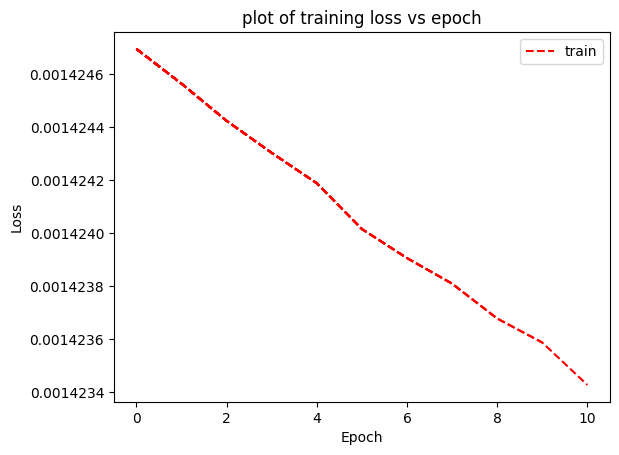

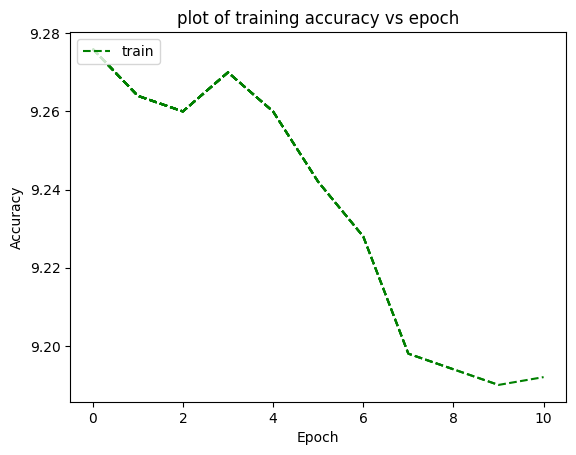

In [53]:
featLength = 2+5+2
# Initilaizing the model
model = perceptron(featLength).to(device)
criterion = nn.MSELoss() 
model = train_model(model,criterion,num_epochs=100,learning_rate=1) # Training the model